# Downloading and processing GHI and temperature data.

# Introduction

This script will allow you to download hourly Global Horizontal Irradiance (GHI) and Temperature as Point Data from the NASA available products in the MERRA-2 (Modern Era Retrospective analysis for Research and Applications, version 2). MERRA-2 is the latest version of global atmospheric reanalysis for the satellite era produced by [NASA](https://gmao.gsfc.nasa.gov/pubs/docs/Bosilovich785.pdf).

It is important to bear in mind that from MERRA-2, there are several [available products](https://gmao.gsfc.nasa.gov/pubs/docs/Collow1253.pdf). Two products contain key information to calculate solar hourly yielded energy: [M2T1NXRAD](https://disc.gsfc.nasa.gov/datasets/M2T1NXRAD_5.12.4/summary?keywords=M2T1NXRAD) and [M2T1NXSLV](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV). M2T1NXRAD (or tavg1_2d_rad_Nx) is an hourly time-averaged 2-dimensional data collection consisting of radiation diagnostics, while M2T1NXSLV (or tavg1_2d_slv_Nx) is an hourly time-averaged 2-dimensional data collection that consists of meteorology diagnostics at popularly used vertical levels.

It is important for you to create an [account](https://urs.earthdata.nasa.gov/users/new?client_id=C_kKX7TXHiCUqzt352ZwTQ&redirect_uri=http%3A%2F%2Fdisc.gsfc.nasa.gov%2Flogin%2Fcallback&response_type=code) as a first step. Then, follow these instructions on [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files).






### Import necessary modules

In [16]:
from subprocess import Popen
from getpass import getpass
import platform
import os
import shutil
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import time
import requests
import json

### Create prerequisite files

The following Python code will prompt you for your Earthdata username and password before generating and storing these three files in their appropriate locations for Windows, Linux, or macOS operating systems. It can be run multiple times, and each time will overwrite existing credential files (if they already exist). This code can be run inside of this notebook or can be put into its own Python script.
Source: [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)

In [2]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.netrc', 'w') as file:
    file.write('machine {} login {} password {}'.format(urs, getpass(prompt=prompts[0]), getpass(prompt=prompts[1])))
    file.close()
with open(homeDir + '.urs_cookies', 'w') as file:
    file.write('')
    file.close()
with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .netrc, .urs_cookies, and .dodsrc to:', homeDir)

Enter NASA Earthdata Login Username 
(or create an account at urs.earthdata.nasa.gov): ········
Enter NASA Earthdata Login Password: ········
Saved .netrc, .urs_cookies, and .dodsrc to: C:\Users\renec\


# Defining main functions

The following lines will define the path for the .gpkg admin layer and create the necesarry folders to where download the csv files

In [3]:
cntryc = "zm"

# Define path and name of the file#
ROOT_DIR = os.path.abspath(os.curdir)
admin_path = ROOT_DIR + "\\" + 'Input_Data' 
admin_name = "{}_admin.gpkg".format(cntryc)

#Administrative_Layer
admin_map= ROOT_DIR + "\\" + 'Input_Data' + '\\' + "{}_admin.gpkg".format(cntryc)

def new_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")

GHI_centroids= admin_path + "\\" + "Data_MERRA" + "\\" + 'GHI_centroids'
T2M_centroids= admin_path + "\\" + "Data_MERRA" +  "\\" + 'T2M_centroids'

new_folder(GHI_centroids)
new_folder(T2M_centroids)

Folder 'C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids' created.
Folder 'C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids' created.


### Uploading and accessing centroids

The function adm_layer_to_centroids will read the administrative division layer and return a file that containts the centroids (Latitude and Longitude) of the given layer. From those given points, the information for GHI and Temperature will be retrieved to be used in the main script.

In [4]:
def adm_layer_to_centroids(admin_map):
    admin=gpd.read_file(admin_map) #read file
    centroids=admin.centroid #obtain centroids from poligons
    # Extract centroid coordinates
    X = centroids.x
    Y = centroids.y
    
    admin['Longitude'] = centroids.x
    admin['Latitude']= centroids.y
    
    # Drop columns 'ADM1_NAME' and 'geometry'
    admin_centroids = admin.drop(columns=['ADM1_NAME', 'geometry'])
    
    admin_centroids['geometry'] = admin_centroids.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
    admin_centroids.reset_index(inplace=True)
    admin_centroids.rename(columns={'index': 'ID'}, inplace=True)

    #plot
    # Plotting setup
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the admin GeoDataFrame with circles
    admin.plot(ax=ax,  edgecolor='black', facecolor='#F5DEB3')

    # Plot the dissolved GeoDataFrame centroids as x markers
    admin_centroids.plot(ax=ax, marker='x', color='blue', markersize=15)

    # Show the plot
    plt.show()
        
    return admin_centroids

### Function to download Global Horizontal Irradiance

The following script will allow to obtain GHI from [M2T1NXRAD](https://disc.gsfc.nasa.gov/datasets/M2T1NXRAD_5.12.4/summary?keywords=M2T1NXRAD). Notice that within the request parametres (params) the script will retrieved SWDGN (Incident shortwave land) from given Latitudes and Longitudes for the year 2023. This script was partially based on the information provided in [How to Obtain a Time Series at a Single Point using TDS](https://disc.gsfc.nasa.gov/information/howto?keywords=THREDDS&title=How%20to%20Obtain%20a%20Time%20Series%20at%20a%20Single%20Point%20using%20TDS)

In [5]:
def download_GHI(latitude, longitude, centroid_name):
    # URL of the file to download
    url = "https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/ncss/MERRA2_aggregation/M2T1NXRAD.5.12.4/M2T1NXRAD.5.12.4_Aggregation_2023.ncml"

    # Earthdata username and password
    username = "julian_cantor"
    password = "SE4allrocks.!"  # Replace "your_password" with your actual password

    # Request parameters
    params = {
        "var": ["SWGDN"],
        "latitude": str(latitude),
        "longitude": str(longitude),
        "time_start": "2023-01-01T00:30:00Z",
        "time_end": "2023-12-31T23:30:00Z",
        "accept": "csv_file"
    }

    # Perform HTTP GET request with authentication
    response = requests.get(url, auth=(username, password), params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the content to a file
        filename = f"{centroid_name}.csv"
        filepath = os.path.join(GHI_centroids, filename)
        with open(filepath, "wb") as f:
            f.write(response.content)
        print(f"File downloaded successfully: {filepath}")
    else:
        print("Failed to download the file. Status code:", response.status_code)

# Example usage:
# download_data(-14.82, 28.07, "Centroid1")  # Example latitude and longitude with centroid name


### Function to download temperature

The following script will allow to obtain air temperature at 2 meters from [M2T1NXSLV](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV). Notice that within the request parametres (params) the script will retrieved T2M (2-meter air temperature) from given Latitudes and Longitudes for the year 2023. This script was partially based on the information provided in [How to Obtain a Time Series at a Single Point using TDS](https://disc.gsfc.nasa.gov/information/howto?keywords=THREDDS&title=How%20to%20Obtain%20a%20Time%20Series%20at%20a%20Single%20Point%20using%20TDS)

In [6]:
def download_T2M(latitude, longitude, centroid_name):
    # URL of the file to download
    url = "https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/ncss/grid/MERRA2_aggregation/M2T1NXSLV.5.12.4/M2T1NXSLV.5.12.4_Aggregation_2023.ncml"
    
   # Earthdata username and password
    username = "julian_cantor"
    password = "SE4allrocks.!"  # Replace "your_password" with your actual password

    # Request parameters
    params = {
        "var": ["T2M"],
        "latitude": str(latitude),
        "longitude": str(longitude),
        "time_start": "2023-01-01T00:30:00Z",
        "time_end": "2023-12-31T23:30:00Z",
        "accept": "csv_file"
    }

    # Perform HTTP GET request with authentication
    response = requests.get(url, auth=(username, password), params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the content to a file
        filename = f"{centroid_name}.csv"
        filepath = os.path.join(T2M_centroids, filename)
        with open(filepath, "wb") as f:
            f.write(response.content)
        print(f"File downloaded successfully: {filepath}")
    else:
        print("Failed to download the file. Status code:", response.status_code)

# Example usage:
# download_data(-14.82, 28.07, "Centroid1")  # Example latitude and longitude with centroid name

### Downloading information

<ipython-input-4-b6c9c767fd54>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=admin.centroid #obtain centroids from poligons


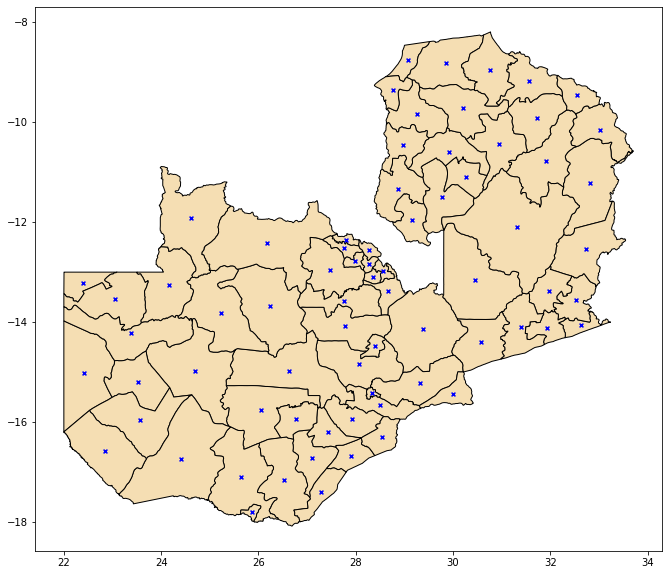

In [7]:
centroids_zambia=adm_layer_to_centroids(admin_map) #Latitude and Longitude for each centroid in Zambia

In [8]:
centroids_zambia.head(3)

,ID,ADM2_NAME,Longitude,Latitude,geometry
0,0,Chibombo,28.070584,-14.828812,POINT (28.07058 -14.82881)
1,1,Kabwe,28.386765,-14.483884,POINT (28.38676 -14.48388)
2,2,Kapiri-Mposhi,27.785939,-14.081682,POINT (27.78594 -14.08168)


### Retrieving GHI information for 2023...

In [9]:
start = time.time()
for index, row in centroids_zambia.iterrows():
    Latitude = row['Latitude']  
    Longitude = row['Longitude'] 
    ADM2_NAME = row['ADM2_NAME']  
    download_GHI(Latitude, Longitude, ADM2_NAME)
end = time.time()
print((end - start)/60, "min")

File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Chibombo.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Kabwe.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Kapiri-Mposhi.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Mkushi.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Mumbwa.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Serenje.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Chililabombwe.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Chingola.csv
File downloade

File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Mongu.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Senanga.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Sesheke.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\GHI_centroids\Shang'ombo.csv
98.10765129327774 min


### Downloading air-temperature at 2 meters hourly data...

In [12]:
start = time.time()
for index, row in centroids_zambia.iterrows():
    Latitude = row['Latitude']  
    Longitude = row['Longitude'] 
    ADM2_NAME = row['ADM2_NAME']  
    download_T2M(Latitude, Longitude, ADM2_NAME)
end = time.time()
print((end - start)/60, "min")

File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Chibombo.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Kabwe.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Kapiri-Mposhi.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Mkushi.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Mumbwa.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Serenje.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Chililabombwe.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Chingola.csv
File downloade

File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Mongu.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Senanga.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Sesheke.csv
File downloaded successfully: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\T2M_centroids\Shang'ombo.csv
95.08213289181391 min


## Processing hourly data and storing it in JSON format

The retrieved information will have the following structure:

In [13]:
df = pd.read_csv(T2M_centroids+"\\" + 'Chadiza.csv')
df.head(10)

,time,"latitude[unit=""degrees_north""]","longitude[unit=""degrees_east""]","T2M[unit=""K""]"
0,2023-01-01T00:30:00Z,-14.06419,32.622547,291.202484
1,2023-01-01T01:30:00Z,-14.06419,32.622547,290.990479
2,2023-01-01T02:30:00Z,-14.06419,32.622547,290.835938
3,2023-01-01T03:30:00Z,-14.06419,32.622547,290.863037
4,2023-01-01T04:30:00Z,-14.06419,32.622547,291.870239
5,2023-01-01T05:30:00Z,-14.06419,32.622547,293.965942
6,2023-01-01T06:30:00Z,-14.06419,32.622547,296.381897
7,2023-01-01T07:30:00Z,-14.06419,32.622547,298.039398
8,2023-01-01T08:30:00Z,-14.06419,32.622547,299.199402
9,2023-01-01T09:30:00Z,-14.06419,32.622547,300.039368


The time is given in ISO 8601 format and does not match the local time; therefore, it is necessary to transform it. The Latitude and Longitude are not going to be used, as the centroid information is in the name of the file; thus, these columns will be dropped. Finally, we need to convert from Kelvin to Celsius degrees. A similar approach for processing GHI is taken. The following functions process the information as described and returns a dictionary to be stored in JSON format.

In [21]:
def process_csv_T2M_file(file_path_T2M):
    df = pd.read_csv(file_path_T2M)
    df.drop(columns=['latitude[unit="degrees_north"]', 'longitude[unit="degrees_east"]', 'time'], inplace=True)
    df.rename(columns={'T2M[unit="K"]': 'T2M'}, inplace=True)
    df['T2M'] = df['T2M'] - 273.15  # Kelvin to Celsius conversion
    last_two_rows = df.tail(3) # Extract the last two rows
    df.drop(df.tail(3).index, inplace=True) # Drop the last two rows from the DataFrame
    df = pd.concat([last_two_rows, df], ignore_index=True) # Concatenate the last two rows to the beginning of the DataFrame
    return df

def process_csv_GHI_file(file_path_GHI):
    df = pd.read_csv(file_path_GHI)
    df.drop(columns=['latitude[unit="degrees_north"]', 'longitude[unit="degrees_east"]', 'time'], inplace=True)
    df.rename(columns={'SWGDN[unit="W m-2"]': 'GHI'}, inplace=True)
    last_two_rows = df.tail(3) # Extract the last two rows
    df.drop(df.tail(3).index, inplace=True) # Drop the last two rows from the DataFrame
    df = pd.concat([last_two_rows, df], ignore_index=True) # Concatenate the last two rows to the beginning of the DataFrame
    return df

# Create a list to store dictionaries for each processed file
data_list = []

# Iterate over all files in the folder
for file_name in os.listdir(GHI_centroids):
  if file_name.endswith(".csv"):  # Check if the file is a CSV file
    file_path_GHI = os.path.join(GHI_centroids, file_name)
    file_path_T2M = os.path.join(T2M_centroids, file_name)

    # Process the CSV files
    processed_value_GHI = process_csv_GHI_file(file_path_GHI)
    processed_Value_T2M = process_csv_T2M_file(file_path_T2M)

    name = os.path.splitext(file_name)[0]

    # Create a dictionary for each file's data
    data_dict = {
        'name': name,
        'GHI': processed_value_GHI.values.tolist() if isinstance(processed_value_GHI, pd.DataFrame) else processed_value_GHI,
        'T2M': processed_Value_T2M.values.tolist() if isinstance(processed_Value_T2M, pd.DataFrame) else processed_Value_T2M
    }

    # Append the dictionary to the data_list
    data_list.append(data_dict)

path_json=ROOT_DIR + "\\" + 'Input_Data' + "\\" + "Data_MERRA"+ "\\" + 'centroids_GHI_T2M.json'
# Consider error handling for potential issues during processing
try:
  # Save the list of dictionaries to a JSON file
  with open(path_json, 'w') as f:
      json.dump(data_list, f)

  print(f"Data stored in: {path_json}")
except (IOError, json.JSONDecodeError) as e:
  print(f"Error saving data to JSON: {e}")
        


Data stored in: C:\Users\renec\Documents\GitHub\MiniGridOpt\Input_Data\Data_MERRA\centroids_GHI_T2M.json
